## Name: Luke Nelson
## Student ID: 5281493709

# <center> Homework 7 </center>

In [2]:
import os
import random
import sys

import cv2
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import tensorflow as tf
import tqdm
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.datasets import cifar10
from keras.layers import (
    Activation,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D,
    Reshape,
    Softmax,
)
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.neighbors import DistanceMetric
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.python.client import device_lib



import io
import codecs
from keras.models import Sequential
from keras.layers import LSTM
from keras.utils import np_utils
import string
from string import punctuation
import tensorflow as tf
#from google.colab import files
import urllib.request
from sklearn.cluster import KMeans
from skimage.color import rgb2gray


### 1. Generative Models for Text

### (a) In this problem, we are trying to build a generative model to mimic the writing style of prominent British Mathematician, Philosopher, prolific writer, and political activist, Bertrand Russell.

### (b) Download the following books from Project Gutenberg in text format:
### i. The Problems of Philosophy
### ii. The Analysis of Mind
### iii. Mysticism and Logic and Other Essays
### iv. Our Knowledge of the External World as a Field for Scientific Method in Philosophy
### Project Gutenberg adds a standard header and footer to each book and this is not part of the original text. Open the file in a text editor and delete the header and footer.
### To have a better model, download the additional 3 books from the library of congress.

### (c) LSTM: Train an LSTM to mimic Russell's style and thoughts:

### i. Concatenate your text files to create a corpus of Russell's writings.

In [3]:
###########MOUNT THE DRIVE##################
#from google.colab import drive
#drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#Upload the book files
#uploaded=files.upload()

Saving Corpus.txt to Corpus.txt
Saving AIIMAT.txt to AIIMAT.txt
Saving MLOE.txt to MLOE.txt
Saving OKEWFSMP.txt to OKEWFSMP.txt
Saving TAM.txt to TAM.txt
Saving TAMatter.txt to TAMatter.txt
Saving THWP.txt to THWP.txt
Saving TPP.txt to TPP.txt


#### Note: I used the following commented out code to concatenate the txt files in my jupyter notebook and the resulting concatenated file is titled "Corpus.txt" which I have uploaded.

In [21]:
#Create filenames
fileDir = os.path.dirname(os.path.realpath('__file__'))
#files=['../data/Book Files/books/AIIMAT.txt','../data/Book Files/books/MLOE.txt','../data/Book Files/books/OKEWFSMP.txt','../data/Book Files/books/TAM.txt','../data/Book Files/books/TAMatter.txt','../data/Book Files/books/THWP.txt','../data/Book Files/books/TPP.txt']
files=['../data/Book Files/books/MLOE.txt','../data/Book Files/books/OKEWFSMP.txt','../data/Book Files/books/TAM.txt','../data/Book Files/books/TPP.txt']
filenames=[]
for file in files:
    filename = os.path.join(fileDir, file)
    filename = os.path.abspath(os.path.realpath(filename))
    filenames.append(filename)

In [22]:
#Note I'm not including the 3 library of congress files because this is only recommended and TAMatter and THWP for now because they won't open in UTF8
#Read in teh files and concatenate

#Create Output path
fileDir = os.path.dirname(os.path.realpath('__file__'))
output_file = os.path.join(fileDir, '../data/Book Files/books/Corpus.txt')
output_file = os.path.abspath(os.path.realpath(output_file))


with open(output_file, 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                outfile.write(line)

#We now have our corpus of concatenated files
corpus= os.path.join(fileDir, '../data/Book Files/books/Corpus.txt')
corpus = os.path.abspath(os.path.realpath(corpus))

In [4]:
#######################Delete this in jupyter############
#This is how I open the file in Google Colab
#corpus=open('/content/gdrive/My Drive/HW7/Corpus.txt',"r")

In [23]:
corpus=open(corpus)

### ii. Use a character-level representation for this model by using extended ASCII that has N=256 characters. Each character will be encoded into an integer using its ASCII code. Rescale the integers to the range [0,1], because LSTM uses a sigmoid activation function. LSTM will receive the rescaled integers as its input. 

#### NOTE: for this question I referenced the following link which served as a great example for how to do LSTM. I directly utilized a number of lines of code from this website: https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/

In [24]:
#########Change this to what you have in your jupyter notebook###########
#Remove punctuation from the file
#remove = dict.fromkeys(map(ord, '\n ' + string.punctuation))

#with open(corpus) as inputfile:
#    raw_text = inputfile.read().translate(remove)

#change corpus to lowercase
corpus=corpus.read()
raw_text=corpus.lower()

raw_text = raw_text.translate(str.maketrans("", "", punctuation))
raw_text=raw_text.replace("\n", "")
raw_text=raw_text.replace("\xa0", "")
raw_text=raw_text.replace("\ufeff", "")

#Map unique characters to integers
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))

#Summary of what we have so far
num_chars = len(raw_text)
num_vocab = len(chars)
print("Total Number of Characters: ", num_chars)
print("Total number of unique characters: ", num_vocab)

Total Number of Characters:  1507088
Total number of unique characters:  73


In [25]:
char_to_int_rescaled=dict()
for a,b in char_to_int.items():
    char_to_int_rescaled[a]=b/(num_vocab-1)

#Convert the text to integers and then rescale them to range [0,1]
encoded_text = np.array([char_to_int[c] for c in raw_text])

print('Here is the dictionary of characters to numbers:\n',char_to_int)
print('Here is the dictionary of characters rescaled to range [0,1]:\n',char_to_int_rescaled)

Here is the dictionary of characters to numbers:
 {' ': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10, 'a': 11, 'b': 12, 'c': 13, 'd': 14, 'e': 15, 'f': 16, 'g': 17, 'h': 18, 'i': 19, 'j': 20, 'k': 21, 'l': 22, 'm': 23, 'n': 24, 'o': 25, 'p': 26, 'q': 27, 'r': 28, 's': 29, 't': 30, 'u': 31, 'v': 32, 'w': 33, 'x': 34, 'y': 35, 'z': 36, '§': 37, '·': 38, 'â': 39, 'æ': 40, 'è': 41, 'é': 42, 'ë': 43, 'î': 44, 'ï': 45, 'ô': 46, 'ö': 47, 'ü': 48, 'œ': 49, 'ŭ': 50, 'α': 51, 'β': 52, 'γ': 53, 'η': 54, 'θ': 55, 'ι': 56, 'κ': 57, 'λ': 58, 'ν': 59, 'ο': 60, 'π': 61, 'ρ': 62, 'σ': 63, 'τ': 64, 'φ': 65, 'ὴ': 66, 'ή': 67, 'ί': 68, 'ὸ': 69, 'ό': 70, '′': 71, '″': 72}
Here is the dictionary of characters rescaled to range [0,1]:
 {' ': 0.0, '0': 0.013888888888888888, '1': 0.027777777777777776, '2': 0.041666666666666664, '3': 0.05555555555555555, '4': 0.06944444444444445, '5': 0.08333333333333333, '6': 0.09722222222222222, '7': 0.1111111111111111, '8': 0.125, '9': 0

### iii. Choose a window size, eg. W=100.

#### Answer: for my window size I will be choosing W=100

### iv. Inputs to the network will be the first W-1=99 characters of each sequence, and the output of the network will be the Wth character of the sequence. ....The second input will be BRAC and the second output will be A, etc.

#### Note: I utilized the following code from this website. This function allows us to convert our samples into multipl (input, target) samples:
https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/

In [7]:
# prepare the dataset of input to output pairs encoded as integers
seq_length = 99
dataX = []
dataY = []
for i in range(0, num_chars - seq_length, 1):
    seq_in = raw_text[i:i + seq_length]
    seq_out = raw_text[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)
print('Window Size:',seq_length+1)

Total Patterns:  1506989
Window Size: 100


### v. Note that the output has to be encoded using a one-hot encoding scheme with N=256 (or less) elements. This means that the network reads integers, but outputs a vector of N=256 (or less) elements.

#### Note: I utilized the following code from this website. This function allows us to convert our samples into multipl (input, target) samples:
https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/

In [8]:
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(num_vocab)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)

### vi. Use a single hiddenlayer for the LSTM with N=256 (or less) memory units.

In [9]:
#Build the Model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 73)                18761     
Total params: 282,953
Trainable params: 282,953
Non-trainable params: 0
_________________________________________________________________


### vii. Use a Softmax output layer to yield a probability prediction for each of the characters between 0 and 1. This is actually a character classification problem with N classes. Choose log loss (cross entropy) as the objective function for the network (research what it means).

#### Based on my research on cross entropy, I found this description to be the most informative:
"Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. So predicting a probability of .012 when the actual observation label is 1 would be bad and result in a high loss value. A perfect model would have a log loss of 0.<br>
As the predicted probability approaches 1, log loss slowly decreases. As the predicted probability decreases, however, the log loss increases rapidly. Log loss penalizes both types of errors, but especially those predictions that are confident and wrong!
<br>
Cross-entropy and log loss are slightly different depending on context, but in machine learning when calculating error rates between 0 and 1 they resolve to the same thing."
#### I pulled this snippet from the following source:
https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#:~:text=Cross%2Dentropy%20loss%2C%20or%20log,diverges%20from%20the%20actual%20label.&text=As%20the%20predicted%20probability%20decreases,the%20log%20loss%20increases%20rapidly.

### viii. We do not use a test dataset. We are using the whole training dataset to learn the probability of each character in a sequence. We are not seeking for a very accurate model. Instead we are interested in a generalization of the dataset that can mimic the gist of the text.

### ix. Choose a reasonable number of epochs for training, consider your computational power (e.g. 30, although the network will need more epochs to yield a better model).

#### I have chosen to use 10 epochs

### x. Use model checkpointing to keep the network weights to determine each time an improvement in loss is observed at the end of the epoch. Find the best set of weights in terms of loss.

In [12]:
# define the checkpoint
fileDir = os.path.dirname(os.path.realpath('__file__'))
filepath = os.path.join(fileDir, '../data/results/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5')
filepath = os.path.abspath(os.path.realpath(filepath))

#filepath="/content/gdrive/My Drive/HW7/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [13]:
#Fit the model with 10 epochs
model.fit(X, y, epochs=10, batch_size=256, callbacks=callbacks_list)

Epoch 1/30
1506989/1506989 [==============================] - 1391s 923us/step - loss: 1.9413

Epoch 00001: loss improved from inf to 1.94132, saving model to /content/gdrive/My Drive/HW7/weights-improvement-01-1.9413.hdf5
Epoch 2/30
1506989/1506989 [==============================] - 1383s 918us/step - loss: 1.9624

Epoch 00002: loss did not improve from 1.94132
Epoch 3/30
1506989/1506989 [==============================] - 1385s 919us/step - loss: 1.8853

Epoch 00003: loss improved from 1.94132 to 1.88534, saving model to /content/gdrive/My Drive/HW7/weights-improvement-03-1.8853.hdf5
Epoch 4/30
1506989/1506989 [==============================] - 1398s 928us/step - loss: 1.8750

Epoch 00004: loss improved from 1.88534 to 1.87498, saving model to /content/gdrive/My Drive/HW7/weights-improvement-04-1.8750.hdf5
Epoch 5/30
1506989/1506989 [==============================] - 1385s 919us/step - loss: 1.8607

Epoch 00005: loss improved from 1.87498 to 1.86067, saving model to /content/gdrive/My

#### I decided to go with 10 epochs because doing any more caused the google collab gpus to time out. Note: the file with the lowest error has been included in my data/results folder as follows. This is the file I have uploaded to read the weights: /data/results/weights-improvement-10-1.7973.hdf5



In [14]:
#Try to predict text noww
# load the network weights
fileDir = os.path.dirname(os.path.realpath('__file__'))
filename = os.path.join(fileDir, '../data/results/weights-improvement-10-1.7973.hdf5')
filename = os.path.abspath(os.path.realpath(filename))



#filename = "/content/gdrive/My Drive/HW7/weights-improvement-10-1.7973.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [15]:
#Generate the text
int_to_char = dict((i, c) for i, c in enumerate(chars))

seed = "There are those who take mental phenomena naively, just as they would physical phenomena. This school of psychologists tends not to emphasize the object."

#Translate seed to integers
seed=seed.lower()
seed = seed.translate(str.maketrans("", "", punctuation))
seed_ints=[]
seed_ints.append([char_to_int[char] for char in seed])
seed_ints=seed_ints[0]

print('Generated Text:')
# generate characters
for i in range(1000):
    x = np.reshape(seed_ints, (1, len(seed_ints), 1))
    x = x / float(num_vocab)
    x = x[0][-99:]
    x = np.reshape(x,(1,99,1))
    prediction = model.predict(x, verbose=0)
    index = np.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in seed_ints]
    sys.stdout.write(result)
    seed_ints.append(index)
    seed_ints = seed_ints[1:len(seed_ints)]

Generated Text:
 which is the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sense and the sens

# QUESTION 2

### 2. (Deep) CNN for Image Colorization

### (a) This assignment uses a convolutional neural network for image colorization which turns a grayscale image to a colored image. By converting an image to grayscale, we loose color information, so converting a grayscale image back to a colored version is not an easy job. We will use the CIFAR-10 dataset. Download the dataset.

In [1]:
from keras.datasets import cifar10
#For info on the dataset check here: http://www.cs.toronto.edu/~kriz/cifar.html

Using TensorFlow backend.


In [2]:
cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


((array([[[[ 59,  62,  63],
           [ 43,  46,  45],
           [ 50,  48,  43],
           ...,
           [158, 132, 108],
           [152, 125, 102],
           [148, 124, 103]],
  
          [[ 16,  20,  20],
           [  0,   0,   0],
           [ 18,   8,   0],
           ...,
           [123,  88,  55],
           [119,  83,  50],
           [122,  87,  57]],
  
          [[ 25,  24,  21],
           [ 16,   7,   0],
           [ 49,  27,   8],
           ...,
           [118,  84,  50],
           [120,  84,  50],
           [109,  73,  42]],
  
          ...,
  
          [[208, 170,  96],
           [201, 153,  34],
           [198, 161,  26],
           ...,
           [160, 133,  70],
           [ 56,  31,   7],
           [ 53,  34,  20]],
  
          [[180, 139,  96],
           [173, 123,  42],
           [186, 144,  30],
           ...,
           [184, 148,  94],
           [ 97,  62,  34],
           [ 83,  53,  34]],
  
          [[177, 144, 116],
           [16

### (b) From the train and test dataset, extract the class birds. We will focus on this class, which has 6000 members.

In [5]:
#Define the train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#Birds have the label 2, so we will index both training and test for only these
#Test
bird_indexes_test=np.where(y_test == 2)
bird_indexes_test=bird_indexes_test[0]

#Test
bird_indexes_train=np.where(y_train == 2)
bird_indexes_train=bird_indexes_train[0]

#Change train and test sets to only include the birds yeet
x_train=x_train[bird_indexes_train]
y_train=y_train[bird_indexes_train]

x_test=x_test[bird_indexes_test]
y_test=y_test[bird_indexes_test]



### (c) Those 6000 images have 6000 x 32 x 32 pixels. Choose at least 10% of the pixels randomly. It is strongly recommended that you choose a large number or all of the pixels. You will have between P=614400 and P=6144000 pixels. Each pixel is an RGB vector with three elements.

Example of original image:


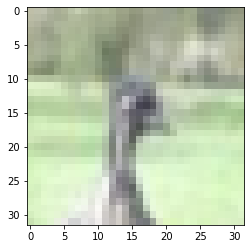

In [6]:
X_data = np.concatenate((x_train,x_test))
y_data = np.full((6000,), 2)

print('Example of original image:')
plt.imshow(X_data[7])

#### I have decided to choose all of the pixels

### (d) Run k-means clustering on the P vectors using k=4. The centers of the clusters will be your main colors. Convert the colored images to k-color images by converting each pixel's value to the closest main color in terms of Euclidean distance. These are the outputs of your network, whose each pixel falls in one of those k classes.

In [7]:
# reshape to correct dimensions
X_data_r = X_data.reshape(-1, 3)
k_means = KMeans(n_clusters=4, random_state=7, n_init=10).fit(X_data_r)
colors = k_means.cluster_centers_
y_pred = k_means.labels_

Example of converted pic:


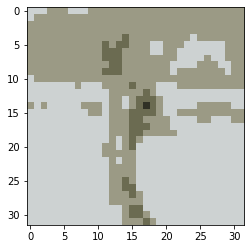

In [8]:
X_convert = np.array(
        [colors[y_pred[i]] for i in range(len(X_data_r))], dtype=np.uint8
).reshape(-1, 32, 32, 3)

print('Example of converted pic:')
plt.imshow(X_convert[7])

### (e) Use any tool (e.g., openCV or scikit-learn) to obtain grayscale 32 x 32 x 1 images from the original 32 x 32 x 3 images. The grayscale images are inputs of your network.

#### After some research, I've decided to use sklearn's image.color module. More information on this module can be found here: https://scikit-image.org/docs/dev/api/skimage.color.html

Here is the grayscale image:


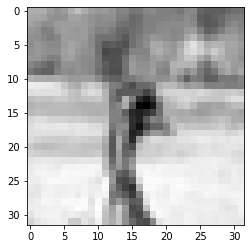

In [9]:
X_grayscale = np.array([rgb2gray(X_data[i]) for i in range(len(X_data))])
print('Here is the grayscale image:')
plt.imshow(X_grayscale[7], cmap=plt.cm.gray)

### (f) Set up a deep convolutional neural network with two convolution layers (or more) and two (or more) MLP layers. Use 5 x 5 filters and a softmax output layer. Determine the number of filters, strides, and whether or not to use padding yourself. Use a minimum of one max pooling layer. Use a classification scheme, which means your output must determine one of the k=4 color classes for each pixel in your grayscale image...Report the train and test errors and visually compare the aritificially colored version of the first 10 images in the test set with the original images.

In [10]:
#One Hot Encode
one_hot = OneHotEncoder(handle_unknown='ignore')
one_hot_sample=[[0],[1],[2],[3]]
one_hot.fit(one_hot_sample)

#Transform
y_OH = one_hot.transform(y_pred.reshape(-1, 1)).toarray().astype(int).reshape(-1, 32, 32, 4)
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_grayscale.reshape(-1, 32, 32, 1), y_OH, test_size=0.1, random_state=7)

In [13]:
#Create the model
#2 convolution layers
#2 MLP Layers
#5x5 filters
#softmax output layer
#max pooling layer
#5 Epochs

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1, 1), 
                        padding='same', input_shape=(32,32,1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),
    keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1, 1), 
                        padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),
    keras.layers.Dense(4096, activation="softmax"),
    keras.layers.Dense(4, activation="softmax")
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 64)        1664      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dense_3 (Dense)              (None, 32, 32, 4096)      266240    
_________________________________________________________________
dense_4 (Dense)              (None, 32, 32, 4)         16388     
Total params: 386,756
Trainable params: 386,756
Non-trainable params: 0
________________________________________________

In [40]:
#Compile and fit the model
from google.colab import files
#files.download('filename.csv')


#30 epochs
epochs=30

#output file location
#output = "./content/"
model_save_name = 'cnn_q2.hdf5'
checkpoint = F"/content//{model_save_name}" 
#torch.save(model.state_dict(), path)

model.compile(optimizer=keras.optimizers.SGD(0.001), metrics=["accuracy"], loss='categorical_crossentropy')

#checkpoint = os.path.join(output, 'cnn_q2.hdf5')
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint,
    save_weights_only= True
)
earlyStop = keras.callbacks.EarlyStopping(patience = 5, min_delta = 1e-4)

model_run = model.fit(X_train_g, y_train_g, epochs=epochs, 
                    validation_data=(X_test_g, y_test_g), 
                    callbacks=[checkpoint_callback, earlyStop])

Train on 5400 samples, validate on 600 samples
Epoch 1/30
5400/5400 [==============================] - 58s 11ms/step - loss: 1.3710 - accuracy: 0.3354 - val_loss: 1.3717 - val_accuracy: 0.3268
Epoch 2/30
5400/5400 [==============================] - 57s 11ms/step - loss: 1.3689 - accuracy: 0.3354 - val_loss: 1.3700 - val_accuracy: 0.3268
Epoch 3/30
5400/5400 [==============================] - 57s 11ms/step - loss: 1.3669 - accuracy: 0.3354 - val_loss: 1.3684 - val_accuracy: 0.3268
Epoch 4/30
5400/5400 [==============================] - 57s 11ms/step - loss: 1.3651 - accuracy: 0.3354 - val_loss: 1.3669 - val_accuracy: 0.3268
Epoch 5/30
5400/5400 [==============================] - 57s 11ms/step - loss: 1.3635 - accuracy: 0.3354 - val_loss: 1.3656 - val_accuracy: 0.3268
Epoch 6/30
5400/5400 [==============================] - 57s 11ms/step - loss: 1.3620 - accuracy: 0.3354 - val_loss: 1.3643 - val_accuracy: 0.3268
Epoch 7/30
5400/5400 [==============================] - 57s 11ms/step - loss:

In [41]:
errs={'Epoch_Number':np.arange(1,31,1),'Test_Error':model_run.history['val_loss'],'Train_Error':model_run.history['loss']}
errs=pd.DataFrame(errs)
errs

,Epoch_Number,Test_Error,Train_Error
0,1,1.371719,1.370972
1,2,1.369965,1.368867
2,3,1.368363,1.366930
3,4,1.366896,1.365149
4,5,1.365558,1.363508
5,6,1.364335,1.362001
6,7,1.363215,1.360611
7,8,1.362192,1.359329
8,9,1.361258,1.358150
9,10,1.360407,1.357063


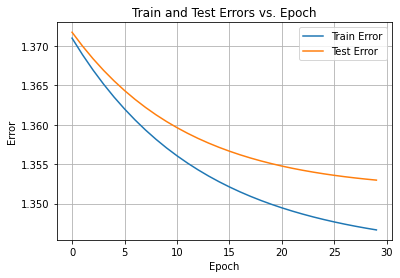

In [42]:
#Plot Errors in Each epoch
plt.plot(model_run.history['loss'])
plt.plot(model_run.history['val_loss'])
plt.gca()
plt.title('Train and Test Errors vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(['Train Error', 'Test Error'], loc='upper right')
plt.grid(True)
plt.show()

In [43]:
#Predict and Reshape
y_pred_colored = model.predict(X_test_g)
y_pred_colored = y_pred_colored.reshape(X_test_g.shape[0] * 32 * 32, 4)
images = []
for i in range(len(y_pred_colored)):
    images.append([int(color) for color in colors[np.argmax(y_pred_colored[i])]])
    
y_test_reshaped = y_test_g.reshape(X_test_g.shape[0] * 32 * 32, 4)
y_test_k_color = []
for k in range(len(y_test_reshaped)):
    y_test_k_color.append([int(color) for color in colors[np.argmax(y_test_reshaped[k])]])
images = np.reshape(images, (-1, 32, 32, 3))
y_test_k_color = np.reshape(y_test_k_color, (-1, 32, 32, 3))


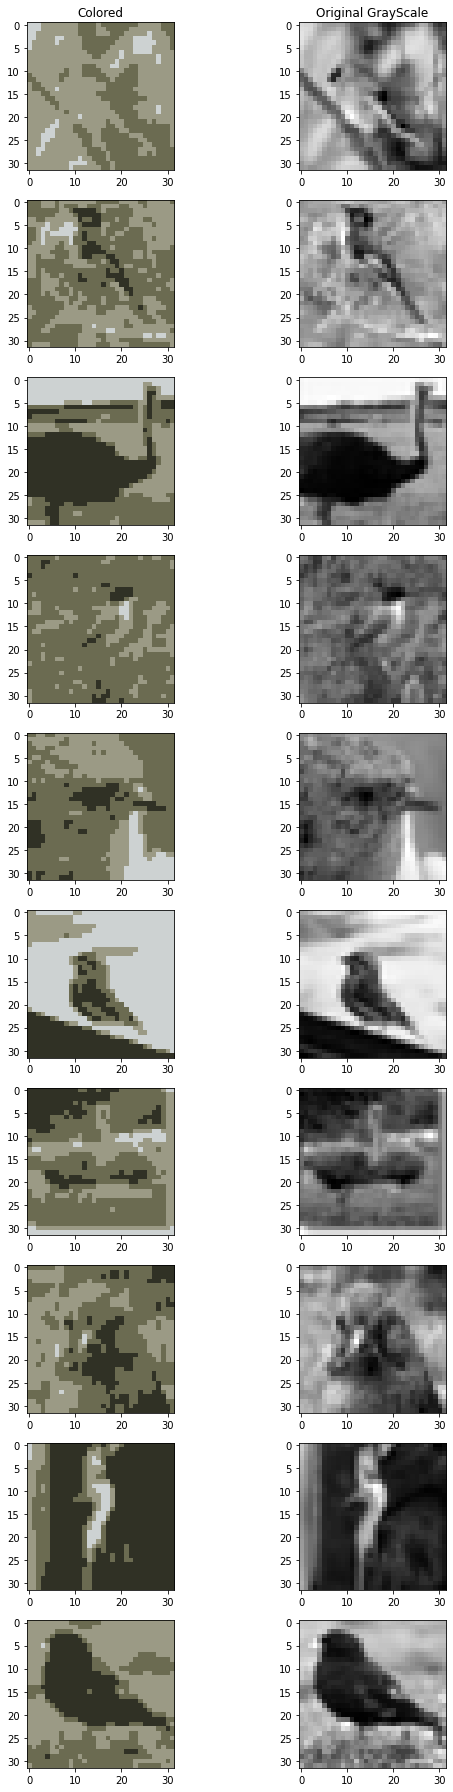

In [45]:
#Plots
fig, axes = plt.subplots(10, 2, figsize=(9, 25))
ax = axes.ravel()

ax[0].imshow(y_test_k_color[1])
ax[1].imshow(X_test_g.reshape(-1,32,32)[1], cmap=plt.cm.gray)

ax[2].imshow(y_test_k_color[2])
ax[3].imshow(X_test_g.reshape(-1,32,32)[2], cmap=plt.cm.gray)

ax[4].imshow(y_test_k_color[3])
ax[5].imshow(X_test_g.reshape(-1,32,32)[3], cmap=plt.cm.gray)

ax[6].imshow(y_test_k_color[4])
ax[7].imshow(X_test_g.reshape(-1,32,32)[4], cmap=plt.cm.gray)

ax[8].imshow(y_test_k_color[5])
ax[9].imshow(X_test_g.reshape(-1,32,32)[5], cmap=plt.cm.gray)

ax[10].imshow(y_test_k_color[6])
ax[11].imshow(X_test_g.reshape(-1,32,32)[6], cmap=plt.cm.gray)

ax[12].imshow(y_test_k_color[7])
ax[13].imshow(X_test_g.reshape(-1,32,32)[7], cmap=plt.cm.gray)

ax[14].imshow(y_test_k_color[8])
ax[15].imshow(X_test_g.reshape(-1,32,32)[8], cmap=plt.cm.gray)

ax[16].imshow(y_test_k_color[9])
ax[17].imshow(X_test_g.reshape(-1,32,32)[9], cmap=plt.cm.gray)

ax[18].imshow(y_test_k_color[10])
ax[19].imshow(X_test_g.reshape(-1,32,32)[10], cmap=plt.cm.gray)

ax[0].set_title("Colored")
ax[1].set_title("Original GrayScale")

fig.tight_layout()
plt.show()